## Demo of audio classifier visualizer.

Visualizes predictions made by an audio classifier model on an audio sample.

## Install dependencies and a classifier

In [1]:
%%capture
%pip install --quiet git+https://github.com/ramayer/elephant-rumble-inference@v0.9.0-rc1

In [2]:
import audio_classifier_visualizer as acv
import elephant_rumble_inference as eri
import IPython.display as ipd
import librosa
import torch
from PIL import Image
from audio_classifier_visualizer import RavenLabel
DEVICE = 'cpu'

## Grab 5 minutes of an interesting audio file.

The part at 1 minute and 30 seconds is easy to hear; most of the rest of the elephant sounds are lower pitched than laptop speakers will play.

In [4]:
audio_path = '/tmp/test.wav'
y,sr = librosa.load(audio_path, sr=None,duration=60*5)
ipd.Audio(y[sr*(60+30):sr*60*2],rate=sr)

## Run an audio classifier on that audio clip

In [4]:
aves_hubert_model          = eri.AvesTorchaudioWrapper().to(DEVICE)
elephant_rumble_classifier = eri.ElephantRumbleClassifier().to(DEVICE)
audio_file_processor       = eri.AudioFileProcessor(aves_hubert_model,elephant_rumble_classifier,device=DEVICE)
elephant_rumble_classifier.load_pretrained_weights('best.pth')
scores = audio_file_processor.classify_wave_file_for_rumbles(audio_path, limit_audio_hours=1)
probabilities = torch.nn.functional.softmax(4*scores/torch.max(torch.abs(scores)), dim=1)
feature_rate = audio_file_processor.rumble_sr / audio_file_processor.audio_samples_per_embedding
torch.save(probabilities,'/tmp/elephant_probabilities.bin')
print(probabilities[0:5])

Classifying hour 0 of /tmp/test.wav torch.Size([0, 1]), torch.Size([1800000, 1]), torch.Size([5120, 1])
tensor([[0.9137, 0.0863],
        [0.7745, 0.2255],
        [0.4351, 0.5649],
        [0.5221, 0.4779],
        [0.5460, 0.4540]])


## Generate a visualization


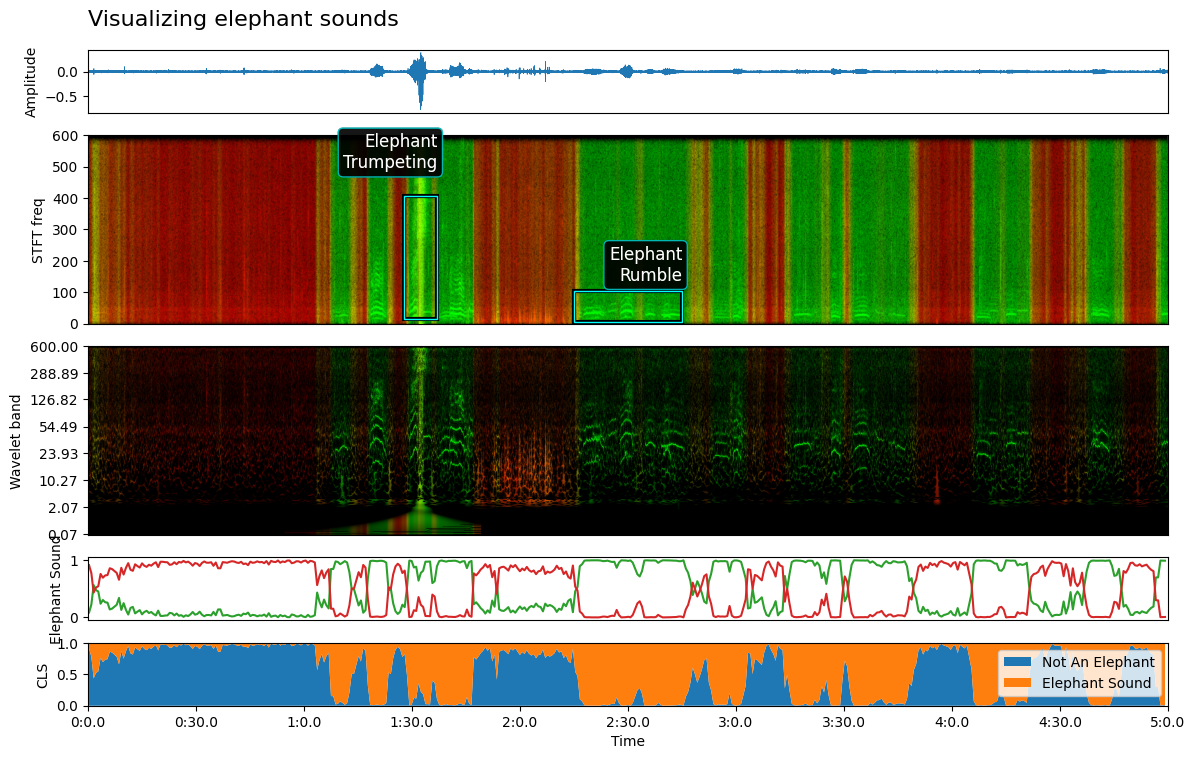

In [9]:

audio_file_processor = acv.AudioFileProcessor()

demo_labels = [
    RavenLabel(bt=88, et=97, lf=20, hf=400, notes="Elephant\nTrumpeting", score=0.95),
    RavenLabel(bt=2*60+15, et=2*60+45, lf=10, hf=100,notes="Elephant\nRumble", score=0.85)
]

audio_file_visualizer = acv.AudioFileVisualizer(audio_path, 
                                                start_time=0, end_time=60*5,
                                                feature_rate=feature_rate,
                                                class_probabilities=probabilities[0:468],
                                                n_fft=512,
                                                sr=1200,
                                                label_boxes=demo_labels,
                                                class_labels=["Not An Elephant", "Elephant Sound"],)

title = "Visualizing elephant sounds"
audio_file_visualizer.visualize_audio_file_fragment(title, width=12, height=8).show()
